# Poker Game Data Processing

Notebook for processing raw poker results data and visualising in various charts, tables, and graphs.

## Setup and Data Processing

In [17]:
import pandas as pd
import csv
import os
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
import plotly.graph_objects as go

In [9]:
path = os.getcwd() + "/dataset.csv"
data = pd.read_csv(path)

In [10]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

df = data.groupby(['date','game_id','player', 'position']).sum() \
         .groupby(level=2).cumsum().reset_index()

df = df.sort_values(by=['date','game_id','position']).reset_index()

df = df[['date', 'game_id', 'player', 'position', 'points']]

df.tail(5)

,date,game_id,player,position,points
25,2020-08-30,5,Lowes,2,7
26,2020-08-30,5,Robbo,3,3
27,2020-08-30,5,Antoni,4,16
28,2020-08-30,5,Steve,5,15
29,2020-08-30,5,Sam,6,12


## Visualising Results

In [11]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters as converter
import seaborn as sns; sns.set()
%matplotlib inline

#### Line Chart For Progress Over Time

In [12]:
# setting the figure size
plt.rcParams["figure.figsize"] = (26, 22)

# setting font family
plt.rcParams['font.family'] = 'Jetbrains Mono'

# plt.rcParams['lines.linewidth'] = 20
# plt.rcParams['lines.markersize'] = 1

# setting plot context
sns.set_context("poster")

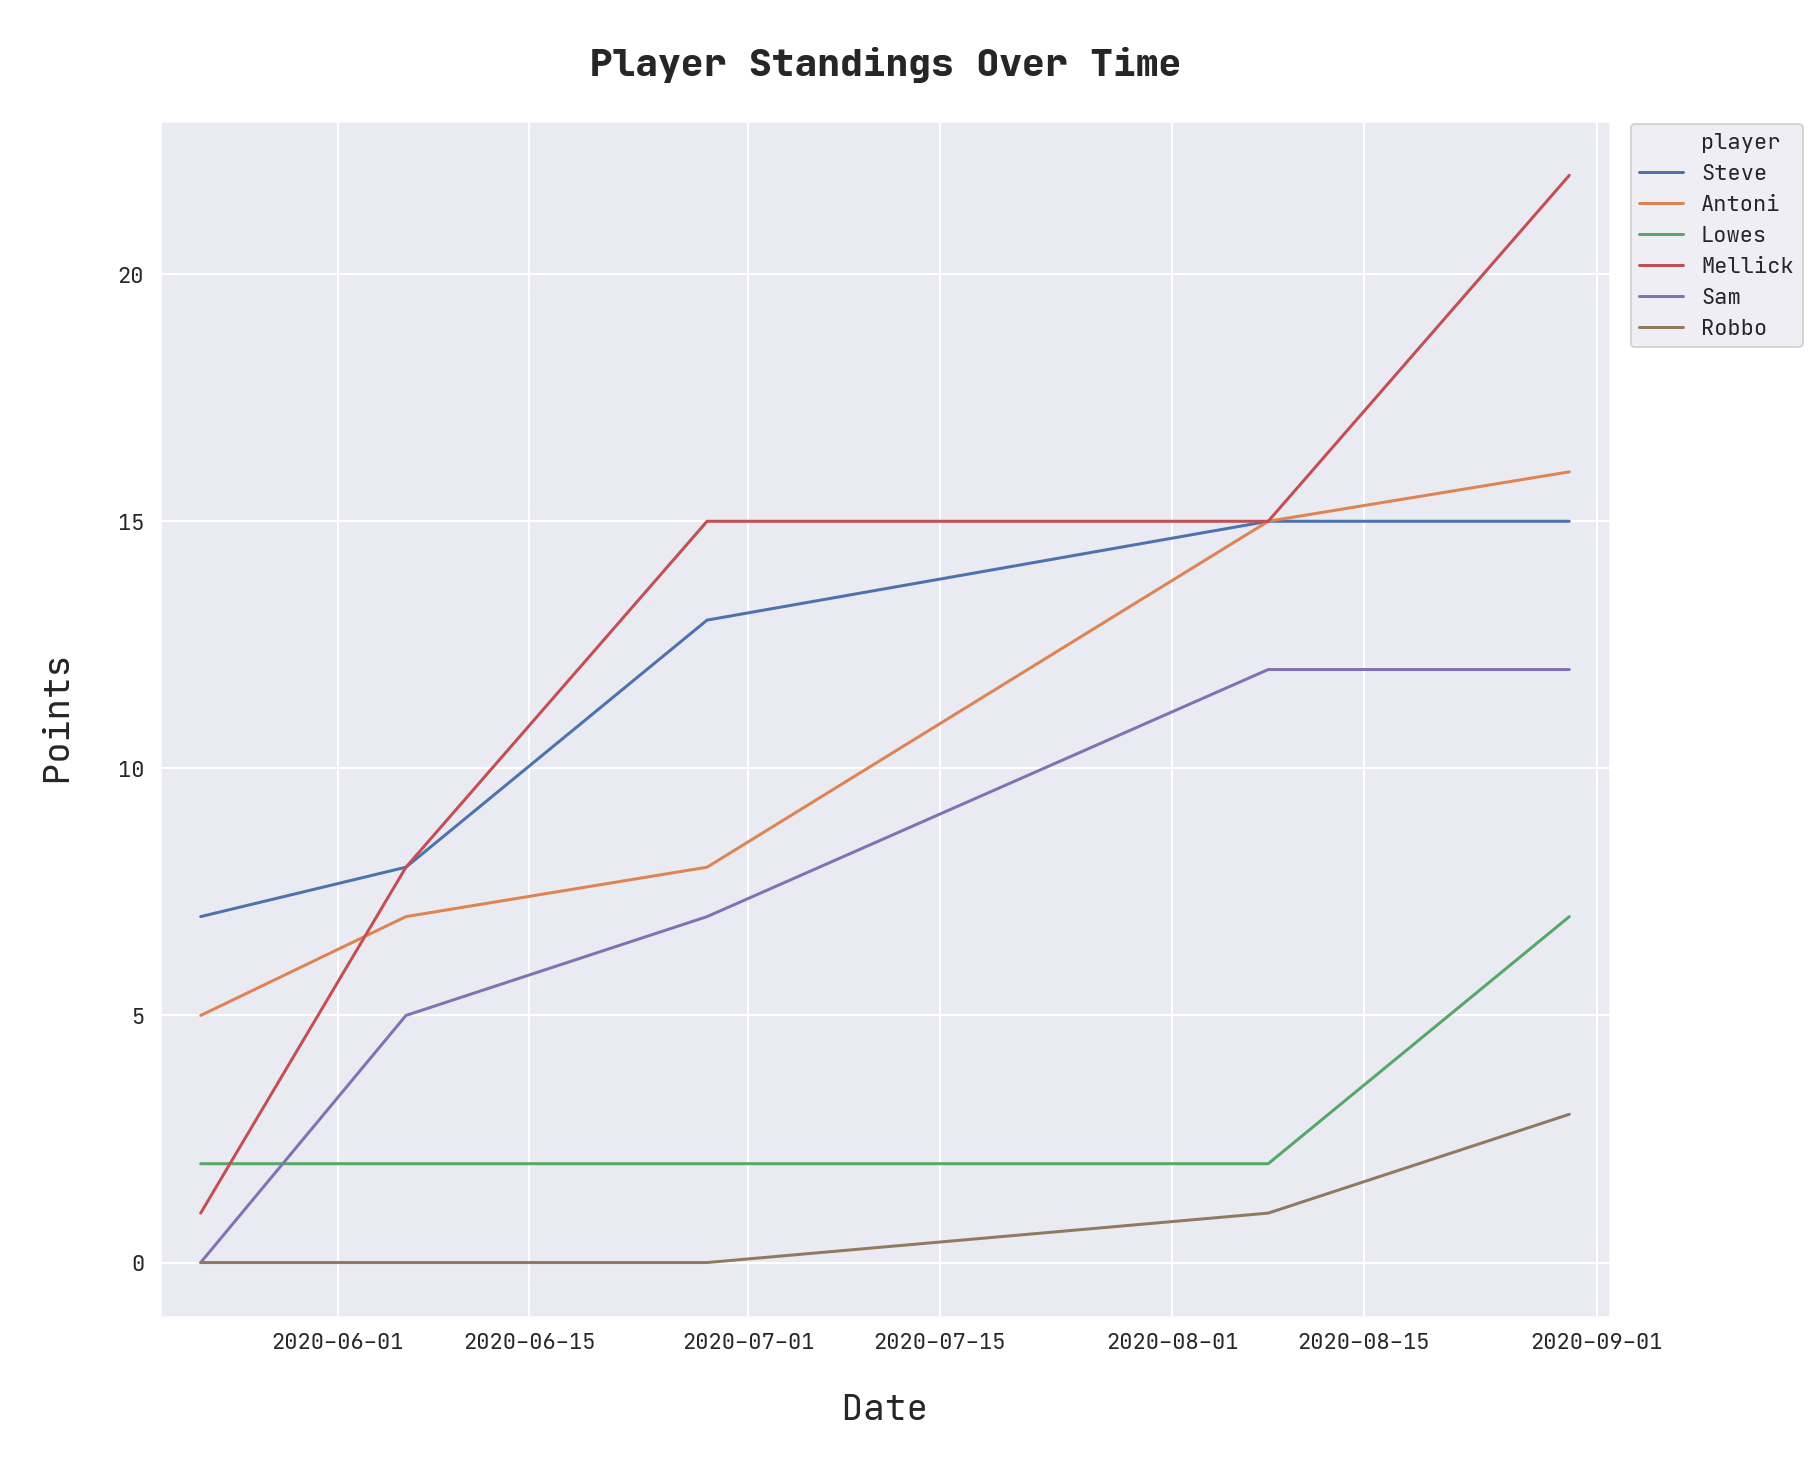

<Figure size 1872x1584 with 0 Axes>

In [13]:
ax = sns.lineplot(x="date", 
                  y="points", 
                  hue="player", 
                  data=df,
                  dashes = True)

# adding labels to axis and title
ax.set_title('\n Player Standings Over Time \n', fontsize = 38, weight='bold')
ax.set_ylabel("\n Points \n", fontsize = 36)
ax.set_xlabel("\n Date \n", fontsize = 36)


min_date = min(df['date']) - timedelta(days=3)
max_date = max(df['date']) + timedelta(days=3)

plt.xlim(min_date, max_date)


# position legend to upper right of the plot and outside the x,y plane
ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.007), ncol=1)

plt.show()
plt.savefig('plots/StandingsOverTime-line.png')

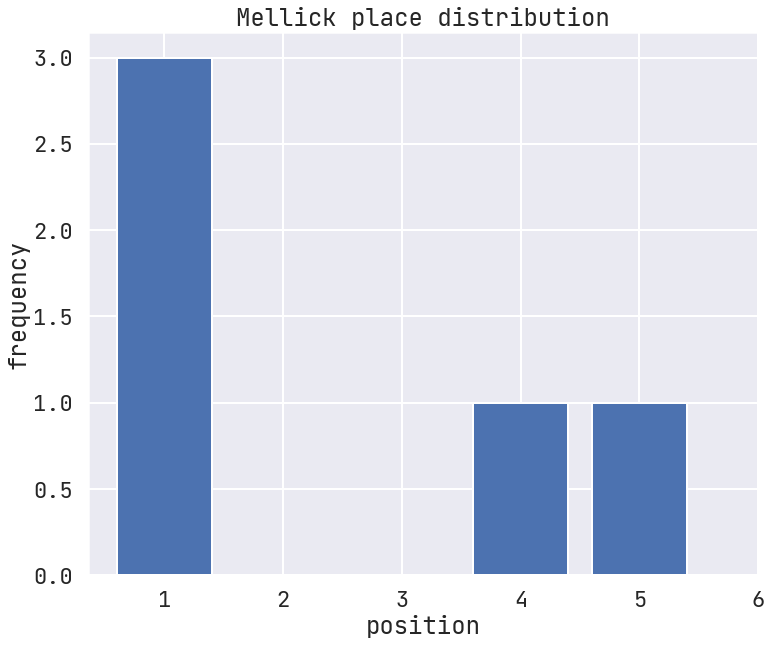

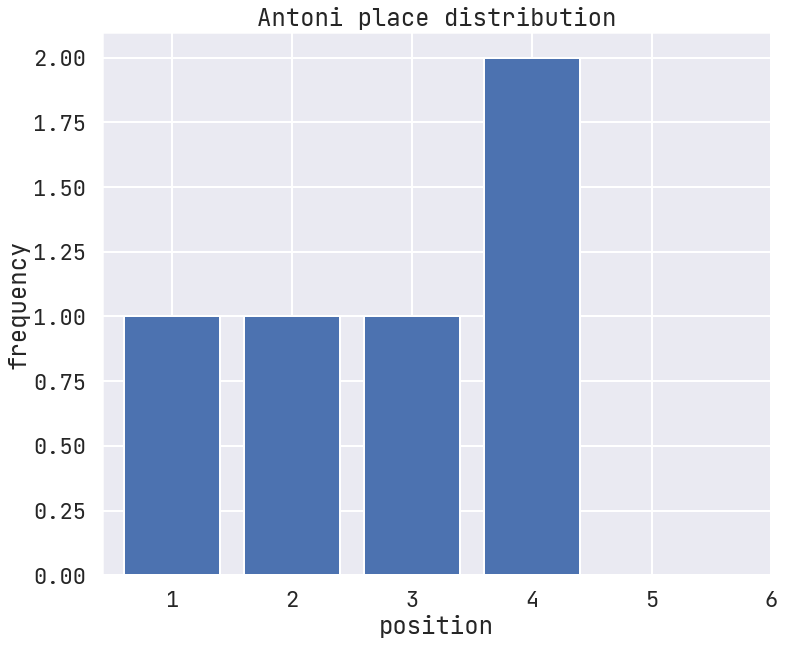

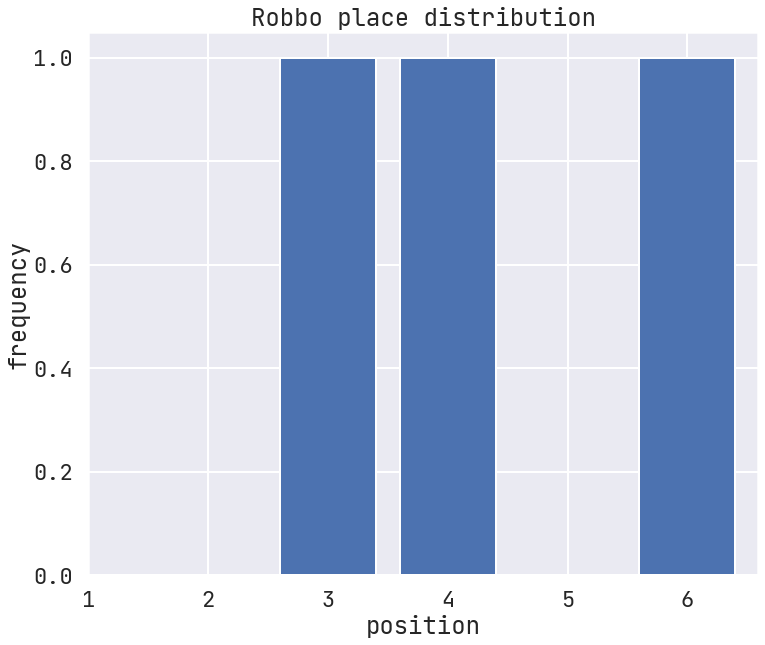

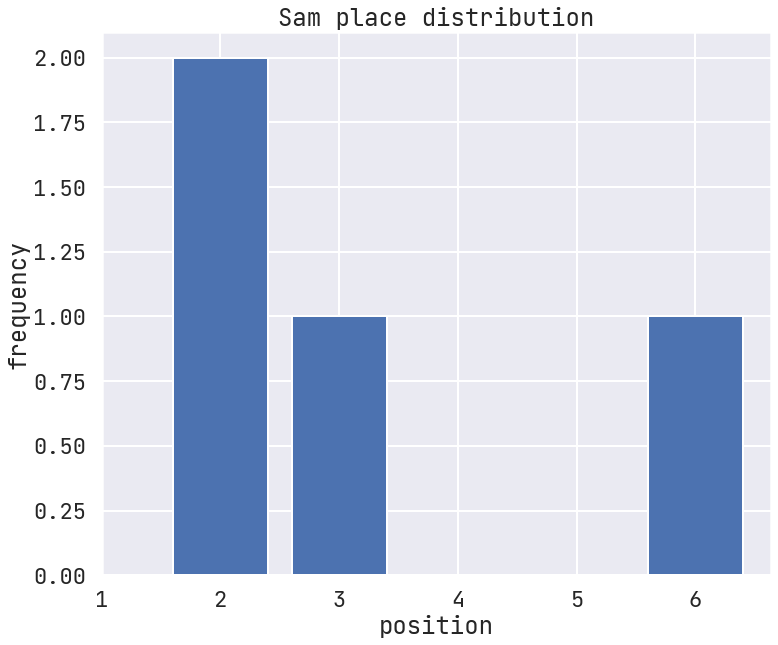

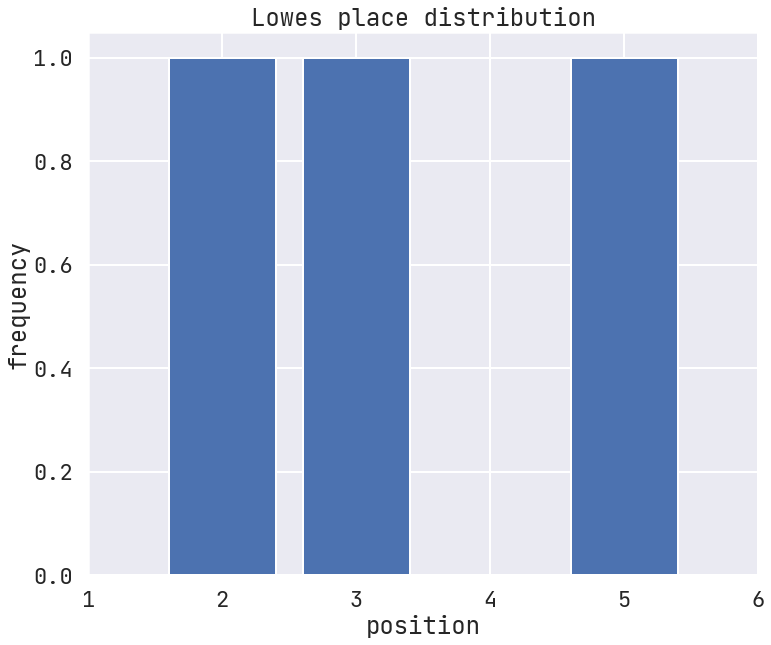

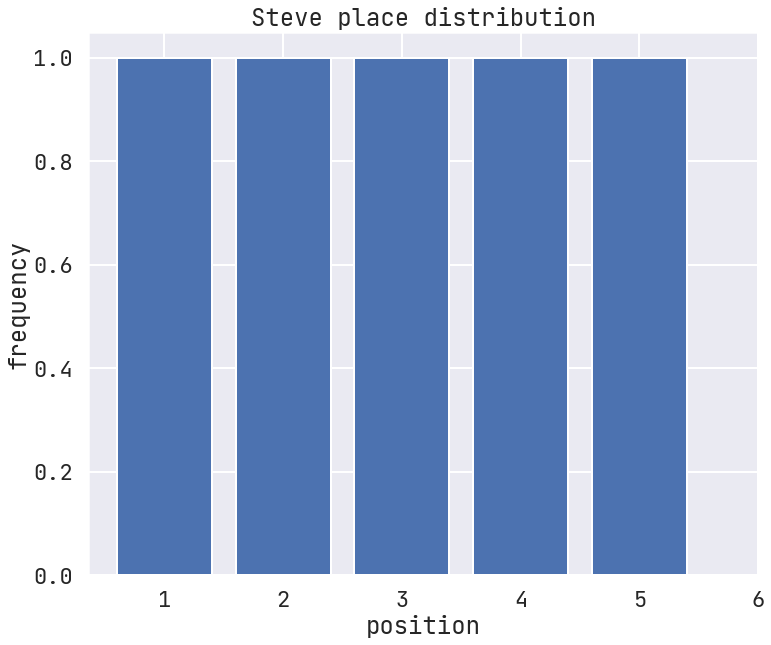

In [14]:
# create new dataframe for this analysis
filter_mask = data[data.played>0]

plt.rcParams["figure.figsize"] = (12,10)

# create list of players
players = list(set(data['player']))

# initialise empty list of scores for each player
scores_steve, scores_mellick, scores_antoni, scores_robbo, scores_sam, scores_lowes = ([] for i in range(0, len(players))) 

# create list of lists of all scores
scores = [scores_steve, scores_mellick, scores_antoni, scores_robbo, scores_sam, scores_lowes]

# zip the list and player names together for iteration
score_dict = dict(zip(players, [0,0,0,0,0,0]))


# iterate through the zipped list and assign the list of values to each list
for player in players:
    score_dict[player] = Counter(filter_mask[filter_mask['player']==player]['position'].values.tolist())
    

for player in players:
    plt.figure()
    plt.bar(score_dict[player].keys(), score_dict[player].values())
    plt.xticks(range(1,7))
    plt.xlabel('position')
    plt.ylabel('frequency')
    plt.title('%s place distribution' % player)
    plt.savefig('plots/%s-hist.png' % player)
    

#### Summary Table

In [15]:
def generate_standings(df: pd.DataFrame()) -> pd.DataFrame():
    """ takes pandas dataframe, performs operations to generate
        a traditional standings style leaderboard
        returns dataframe
    """
    # get unique player names as keys
    players = df['player'].unique()
    players = pd.DataFrame(players, columns=['player']) 

    # getting player points
    points = df.groupby('player').agg({'points': 'sum'})

    # getting total games played
    games_played = df[df.played > 0]
    games_played = games_played["player"].value_counts()
    games_played = games_played.to_frame(name='games_played')

    # joining dataframes
    result = players.join(games_played)
    result = result.join(points).fillna(0)
    result = pd.merge(points, games_played, left_index=True, right_index=True)

    # getting points per game
    result['ppg'] = round((result['points'] / result['games_played']),2)

    # getting count of wins
    wins = df[df['position'] == 1]
    wins = wins['player'].value_counts()
    wins = wins.to_frame(name='wins')

    # join result df to wins
    final_result = result.join(wins)

    # format final result set for presentation in table format
    table = final_result.fillna(0)
    table['wins'] = table['wins'].astype('int64')
    table['games_played'] = table['games_played'].astype('int64')
    table = table[['games_played', 'points', 'ppg', 'wins']]
    table=table.sort_values(by=['points'], ascending=False)
    
    return table

In [59]:
import plotly.io as pio

df = generate_standings(data).reset_index(level=0)
df.rename(columns={"index": "player"}, inplace=True)

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lightgray',
                align='left',
                font=dict(family='Jetbrains Mono',color='black')),
    cells=dict(values=[df.player, df.games_played, df.points, df.ppg, df.wins],
               fill_color='white',
               align='left',
               font=dict(family='Jetbrains Mono',color='black')))
])

pio.write_image(fig, 'plots/table.png')

ValueError: Image generation requires the psutil package.

Install using pip:
    $ pip install psutil

Install using conda:
    $ conda install psutil
